# 上机实验：集成学习

## 任务1：完整AdaBoost的实现

已知基于单层决策树的 AdaBoost 算法的伪代码如下：

- 初始化所有参数，其中样本权重都为 $\frac{1}{n}$
- 迭代次数 `i<itermax:`

   - 调用 `buildStump()` 函数得到最佳的单层决策树
   
   - 将该最佳单层决策树存储到单层决策树数组中

   - 根据当前单层决策树的错误率 $\varepsilon_i$，并根据该错误率计算 $\alpha_i$

   - 更新样本的权重向量 D

   - 更新累积预测值，并计算前 i 个弱分类器集成得到的错误率

   - 如果该错误率等于 0.0，则退出循环
   
- 其中在第 t 轮训练中：

 $$\alpha_t = \dfrac{1}{2}\log (\dfrac{1 - \varepsilon_t}{\varepsilon_t})$$

 $$w_i^{t + 1} = \dfrac{w_i^te^{- \alpha_ty_ih_t(\boldsymbol{x}_i)}}{Z_t}$$

其中 $Z_t$ 为归一化因子。

- 假设现在已经实现了基于加权输入值进行决策的最佳单层决策树生成函数 `buildStump()`与决策函数 `stumpClassify()`；

- 请补全完整的 AdaBoost 训练函数 `adaBoostTrainDS()`；

- 给定一个二分类任务，数据集为描述马疝病的数据集，任务目标为预测患有马疝病的马是否能够存活。现已经把数据集分为训练集 `train_data`、`train_label`和测试集`test_data`、 `test_label`。其中 `train_data` 包含 299 个数据样本，21 个特征；`test_data` 包含 67 个数据样本，21 个特征，数据集的标签取值为 1(存活)和 -1(死亡)；

- 请使用 `adaBoostTrainDS()` 根据马疝病的训练集 `train_data`、`train_label` 训练（迭代数为 `40`）得到一个集成学习模型 `weak_clfs`；

- 根据训练好的集成学习模型 `weak_clfs`，使用`stumpClassify()`对测试集`test_data`进行预测，得到预测结果`pred_label`并结合真实标记`test_label`进行评估。

> 前序代码：stumpClassify() 和 buildStump()

In [45]:
from numpy import mat, zeros, ones, multiply, exp, sign, inf, log

In [46]:
def stumpClassify(dataMatrix, dimen, threshVal, threshIneq):
    preArray = ones((dataMatrix.shape[0], 1)) # 初始化预测为1
    if threshIneq == 'lt':
        preArray[dataMatrix[:, dimen] <= threshVal] = -1.0
    else:
        preArray[dataMatrix[:, dimen] > threshVal] = -1.0
    return preArray

In [47]:
def buildStump(dataArr,classLabels,D):
    # 先定义之后要用到的一些变量
    dataMatrix = mat(dataArr)
    labelMat = mat(classLabels).T
    m, n = dataMatrix.shape
    numSteps = 10.0
    bestStump = {}
    bestClasEst = mat(zeros((m, 1)))
    minError = inf
    for i in range(n):# 对所有特征进行迭代
        rangeMin = dataMatrix[:, i].min()
        rangeMax = dataMatrix[:, i].max()
        stepSize = (rangeMax - rangeMin)/numSteps # 特征的值变化的步长
        for j in range(-1, int(numSteps)+1):# 对所有特征的值进行迭代
            for inequal in ['lt', 'gt']: # 两种标记方式的切换
                threshVal = (rangeMin + float(j) * stepSize)
                predictedVals = stumpClassify(dataMatrix, i, threshVal, inequal)
                errArr = mat(ones((m, 1)))
                errArr[predictedVals == labelMat] = 0
                weightedError = D.T*errArr  # 计算加权错误率
                # print "split: dim %d, thresh %.2f, thresh ineqal: %s, the weighted error is %.3f" % (i, threshVal, inequal, weightedError)
                if weightedError < minError:
                    minError = weightedError
                    bestClasEst = predictedVals.copy()
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
    return bestStump, minError, bestClasEst

In [48]:
#数据加载与预处理 
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report

def load_data(path):
    data = pd.read_csv(path, sep='\t', names=[i for i in range(22)])
    data = np.array(data).tolist()
    x = []; y = []
    for i in range(len(data)):
        y.append(data[i][-1])
        del data[i][-1]
        x.append(data[i])

    x = np.array(x)
    y = np.array(y)

    return x, y
train_data, train_label = load_data('horseColicTraining.txt')
test_data, test_label = load_data('horseColicTest.txt')

> 待完善代码

In [49]:
# 请补全下列代码 #
def adaBoostTrainDS(dataArr, classLabels, itermax=40):
    weakClassArr = [] # 准备一个存储所有弱分类器的空列表
    m = dataArr.shape[0] 
    D = mat(ones((m, 1))/m)   # 初始化所有样本为相同的权重
    aggClassEst = mat(zeros((m, 1))) # 最终集成模型的预测向量
    for i in range(itermax): 
        
        # 获得当前最佳的单层决策树beatStump，错误率error，预测结果classEst
        bestStump, error, classEst = buildStump(dataArr, classLabels, D)
        
        # 计算bestStump对应的alpha，并存储在beatStump字典中（注意error=0的情况）
        # alpha = __________________________
        alpha = float(0.5*log((1.0-error)/max(error, 1e-16)))
        
        bestStump['alpha'] = alpha
        
        # 将当前的最佳单层决策树放入存储列表中
        # __________________________
        weakClassArr.append(bestStump)
        
        # 更新样本权重D
        # __________________________
        expon = multiply(-1*alpha*mat(classLabels).T, classEst)
        
        # 计算集成之前i-1个弱分类器预测的错误率errorRate
        # __________________________
        aggClassEst += alpha*classEst
        aggErrors = multiply(sign(aggClassEst) != mat(classLabels).T, ones((m, 1)))
        errorRate = aggErrors.sum()/m

        
        print ("total error: ", errorRate)
        
        if errorRate == 0.0: break
    return weakClassArr, aggClassEst

# adaboost模型训练
weak_clfs,_ = adaBoostTrainDS(train_data, train_label)
print(weak_clfs[1])

total error:  0.2842809364548495
total error:  0.2842809364548495
total error:  0.2842809364548495
total error:  0.2842809364548495
total error:  0.2842809364548495
total error:  0.2842809364548495
total error:  0.2842809364548495
total error:  0.2842809364548495
total error:  0.2842809364548495
total error:  0.2842809364548495
total error:  0.2842809364548495
total error:  0.2842809364548495
total error:  0.2842809364548495
total error:  0.2842809364548495
total error:  0.2842809364548495
total error:  0.2842809364548495
total error:  0.2842809364548495
total error:  0.2842809364548495
total error:  0.2842809364548495
total error:  0.2842809364548495
total error:  0.2842809364548495
total error:  0.2842809364548495
total error:  0.2842809364548495
total error:  0.2842809364548495
total error:  0.2842809364548495
total error:  0.2842809364548495
total error:  0.2842809364548495
total error:  0.2842809364548495
total error:  0.2842809364548495
total error:  0.2842809364548495
total erro

In [50]:
# adaboost模型预测与评估

# 预测标记向量初始化
pred_label=np.zeros((test_label.shape[0],1))
for clf in weak_clfs: 
    # 使用`stumpClassify()`对测试集`test_data`进行预测
    # pred = __________________________
    pred = stumpClassify(mat(test_data), clf['dim'], clf['thresh'], clf['ineq'])
    # 预测的结果与前面的个体学习器预测结果进行加权融合
    # pred_label = __________________________
    pred_label += clf['alpha']*pred

pred_label = np.sign(pred_label)
print(classification_report(test_label, pred_label))

              precision    recall  f1-score   support

        -1.0       0.56      0.45      0.50        20
         1.0       0.78      0.85      0.82        47

    accuracy                           0.73        67
   macro avg       0.67      0.65      0.66        67
weighted avg       0.72      0.73      0.72        67



## 任务2：sklearn中的AdaBoost

- 对病马疝气病数据集使用 `sklearn.ensemble` 中的 `AdaBoostClassifier`，构建 AdaBoost 模型，完成预测病马的分类任务；
- 请尝试使用不同的超参数，以使得最终模型对于测试集的准确率大于等于` 0.75`，并与自行实现的 AdaBoost分类器结果进行比较。

> 待完善代码

In [51]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import AdaBoostClassifier  

# 构建adaboost模型clf，并基于训练集训练
# clf = __________________________
# __________________________
clf = AdaBoostClassifier(n_estimators=40)
clf.fit(train_data, train_label)

# 使用训练后的clf对测试集进行预测
# pred_label = __________________________
pred_label = clf.predict(test_data)

# 计算模型的正确率
# score = __________________________
score = accuracy_score(test_label, pred_label)

print("Accuracy:", score)

# 查看详细的模型评价报告
print(classification_report(test_label, pred_label))

Accuracy: 0.7611940298507462
              precision    recall  f1-score   support

        -1.0       0.58      0.70      0.64        20
         1.0       0.86      0.79      0.82        47

    accuracy                           0.76        67
   macro avg       0.72      0.74      0.73        67
weighted avg       0.78      0.76      0.77        67



## 任务3：sklearn中的RandomForest

- 加载sklearn中的wine三分类数据集，进行数据集划分；
- 分别使用sklearn中决策树分类器DecisionTreeClassifier与随机森林分类器RandomForestClassifier进行模型训练；
- 进行模型评估与比较；
- 通过交叉验证再次比较决策树分类器与随机森林分类器的分类性能。


In [52]:
from sklearn import tree
from sklearn.datasets import load_wine
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import graphviz
import matplotlib.pyplot as plt

wine = load_wine()
# 划分训练集与测试集
x_train, x_valid, y_train, y_valid = train_test_split(wine.data, wine.target, test_size=0.3)

# 样本输出
pd.concat([pd.DataFrame(wine.data), pd.DataFrame(wine.target)], axis=1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,0
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,2
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,2
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,2
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,2


> 待完善代码

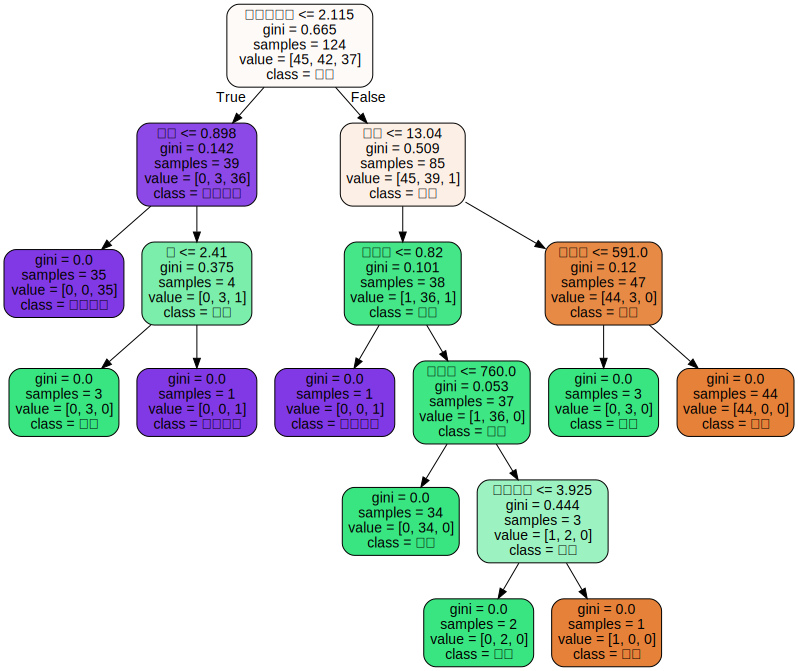

In [53]:
# 实例化决策树分类器与模型训练
# clf = __________________________
# __________________________
clf = DecisionTreeClassifier()
clf.fit(x_train, y_train)

# 决策树可视化
feature_name = ['酒精', '苹果酸', '灰', '灰的碱性', '镁', '总酚', '类黄素', '非黄烷类分类', '花青素', '颜色强度', '色调', '稀释葡萄酒', '脯氨酸']
dot_data = tree.export_graphviz(clf
                                ,feature_names=feature_name
                                ,class_names=["琴酒", "雪梨", "贝尔摩德"]
                                ,filled=True
                                ,rounded=True
                                )
graph = graphviz.Source(dot_data)
graph

In [54]:
# 实例化随机森林分类器与模型训练
# rfc = __________________________(
#     criterion=____________,
#     n_estimators=____________, # 定义个体分类器的个数
#     max_depth=______, # 定义树的深度, 可以用来防止过拟合
#     min_samples_split=______, # 定义至少多少个样本的情况下才继续分叉
#     min_weight_fraction_leaf=______ # 定义叶子节点最少需要包含多少个样本(使用百分比表达), 防止过拟合
#     )
rfc = RandomForestClassifier(
    criterion='gini',
    n_estimators=10,              # 定义个体分类器的个数
    max_depth=None,               # 定义树的深度, 可以用来防止过拟合
    min_samples_split=2,          # 定义至少多少个样本的情况下才继续分叉
    min_weight_fraction_leaf=0.0  # 定义叶子节点最少需要包含多少个样本(使用百分比表达), 防止过拟合
    )
# 模型训练
# __________________________
rfc.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Single Tree:0.9259259259259259
Random Forest:0.9814814814814815
随机森林 AUC = 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      0.97      0.98        29
           2       0.92      1.00      0.96        11

    accuracy                           0.98        54
   macro avg       0.97      0.99      0.98        54
weighted avg       0.98      0.98      0.98        54



/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


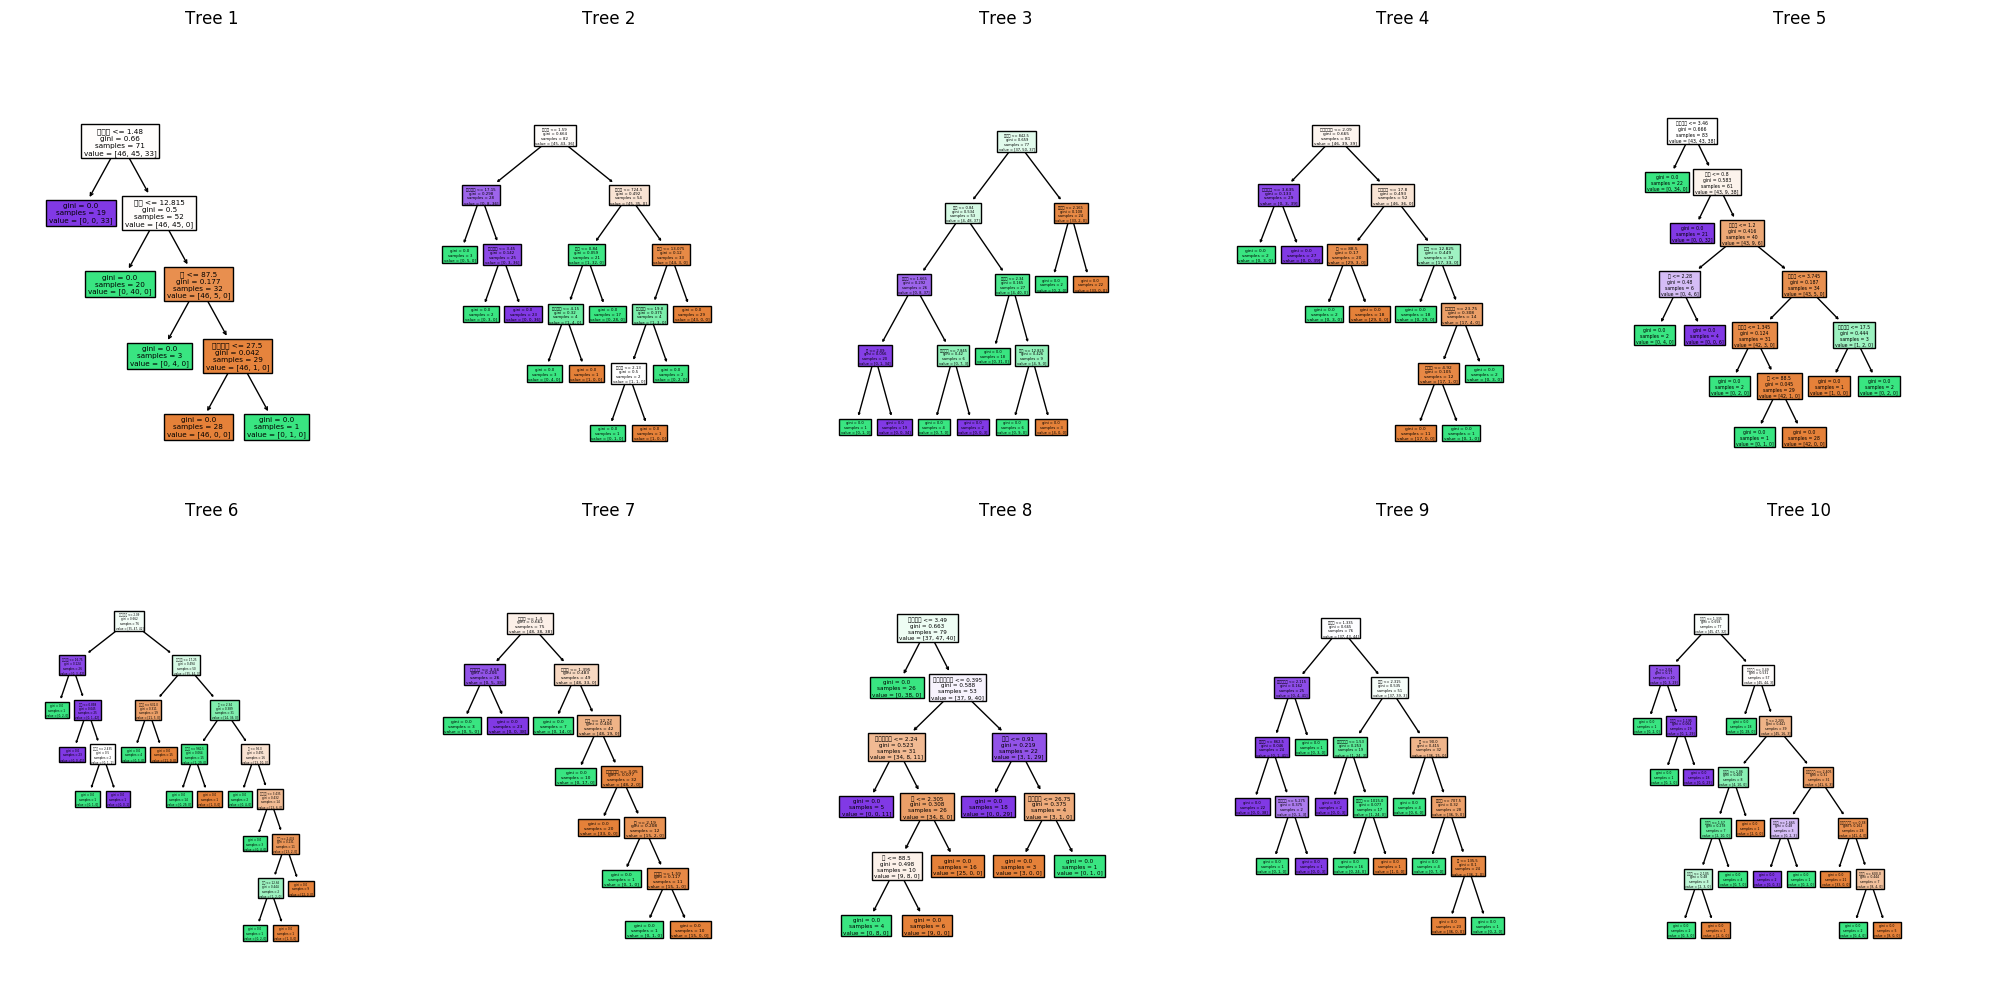

In [59]:
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.tree import plot_tree

# 决策树分类器对测试样本x_valid与y_valid进行评估
score_c = clf.score(x_valid, y_valid)
print("Single Tree:{}".format(score_c))

# 随机森林分类器对测试样本x_valid与y_valid进行评估
score_r = rfc.score(x_valid, y_valid)
print("Random Forest:{}".format(score_r))

# 使用LabelBinarizer函数将多分类标签转换为one-hot编码向量
# encoder = __________________________
# y_valid_one_hot = __________________________
encoder = LabelBinarizer()
y_valid_one_hot = encoder.fit_transform(y_valid)

# 使用roc_auc_score函数计算随机森林分类器对测试样本的auc结果
# rfc_roc_auc = __________________________
rfc_roc_auc = roc_auc_score(y_valid_one_hot, rfc.predict_proba(x_valid), average='macro', multi_class='ovr')
print ("随机森林 AUC = %2.2f" % rfc_roc_auc)
print(classification_report(y_valid, rfc.predict(x_valid)))

# 思考将随机森林中集成的多个决策树进行可视化（选做）
# 请在下方补充
# ________________________

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))

for i in range(len(rfc.estimators_)):
    ax = axes[i // 5, i % 5]
    plot_tree(rfc.estimators_[i], ax=ax, filled=True, feature_names=feature_name)
    ax.set_title(f'Tree {i + 1}')

plt.tight_layout()
plt.show()

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


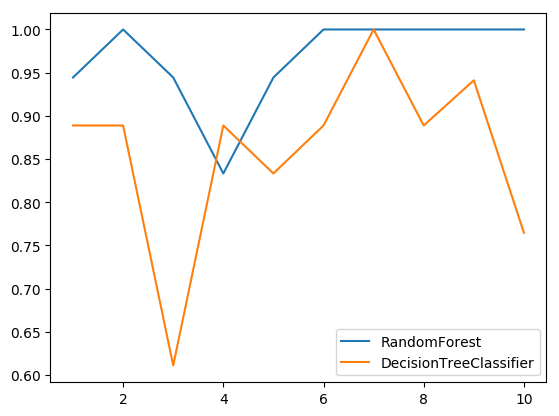

In [60]:
# 交叉验证
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# 使用cross_val_score函数在wine数据上对上述两个分类器进行10折交叉验证
# rfc_s = __________________________
# clf_s = __________________________
rfc_s = cross_val_score(rfc, wine.data, wine.target, cv=10)
clf_s = cross_val_score(clf, wine.data, wine.target, cv=10)

plt.plot(range(1, 11), rfc_s, label="RandomForest")
plt.plot(range(1, 11), clf_s, label="DecisionTreeClassifier")
plt.legend()
plt.show()